In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12,12

from utils import MDP, visualize

# Use seaborn style plots
sns.set()

# Set random generators seeds
np.random.seed(7)

# "Create problem"
mdp = MDP()
T = mdp.get_dynamics(path='data.npy')

# Jack’s Car Rental Problem
#####  
![frozen lake](refs/car_rent.jpg)
#####  

>Jack manages **two locations** for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he **rents it out and is credited \$10** by the national company. If he is **out of cars at that location, then the business is lost**. Cars become available for renting the **day after they are returned**. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of **\$2 per car moved**. We assume that the number of **cars requested and returned at each location are Poisson random variables**, meaning that the probability that the number is $n$ is $\frac{λ^n}{n!}e^{−λ}$, where $λ$ is the expected number. Suppose **$λ$ is 3 and 4 for rental requests** at the first and second locations and **$3$ and $2$ for returns**. To simplify the problem slightly, we assume that there can be **no more than 20 cars at each location** (any additional cars are returned to the nationwide company, and thus **disappear from the problem**) and a maximum of **five cars can be moved** from one location to the other in one night. We take the **discount rate to be $γ = 0.9$** and formulate this as a **continuing finite MDP** [...]"~ _Reinforcement Learning: An Introduction 2nd_

Note that Poisson distribution tells us probability of given number of Poisson processes (independent events) occurring in fixed interval of time, when mean number of Poisson processes occurring in this interval is known.

## Checklist questions:
* What is STATE in this problem?
* What is ACTION in this problem?
* What is REWARD in this problem?
* What is TRANSITION in this problem?
* What is EPISODE in this problem?

## Answer

> [...] formulate this <problem> as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

## Policy, value and dynamics arrays:

* `pi[<num loc. 1>, <num loc. 2>] -> action`

* `V[<num loc. 1>, <num loc. 2>] -> expected return / value`

* `T[<num loc. 1>, <num loc. 2>, <num cars to move>, <next num loc. 1>, <next num loc. 2>] -> prob., reward`  
  We consider cars number in each location AFTER day ends, but BEFORE any car is moved.

In [3]:
STATE_SPACE = T.shape[:2]
print("State space shape: ", STATE_SPACE)
ACTION_SPACE = T.shape[2]
print("Action space size: ", ACTION_SPACE)

# How big is out problem?
print("State-action pairs: ", T[:,:,:,0,0,0].size)
print("Transitions: ", T[:,:,:,:,:,0].size)

State space shape:  (21, 21)
Action space size:  11
State-action pairs:  4851
Transitions:  2139291


# Policy Evaluation

Value function tells us how good current policy is in terms of state values. Policy evaluation gives us (approximation) of current policy value function.

![value interation](refs/policy_eval.png)

Policy evaluation: 0


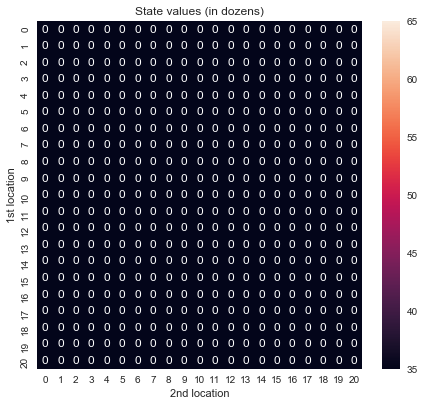

Policy evaluation: 5


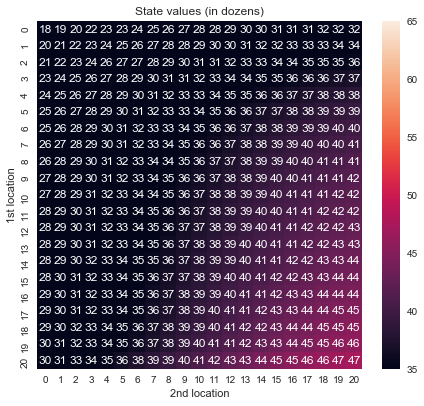

Policy evaluation: 10


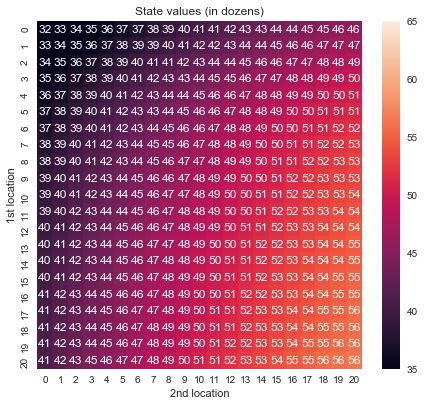

Policy evaluation: 15


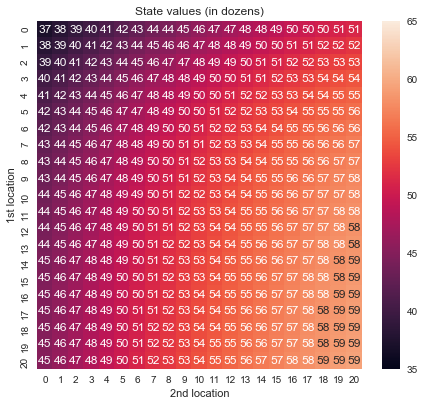

Policy evaluation: 20


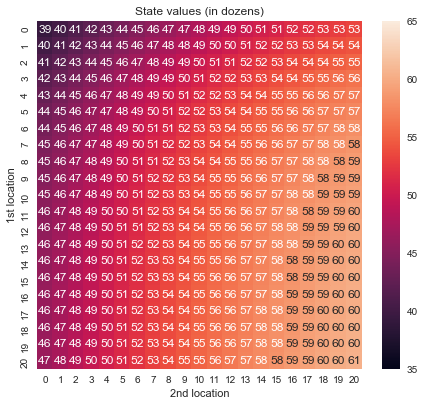

Policy evaluation: 25


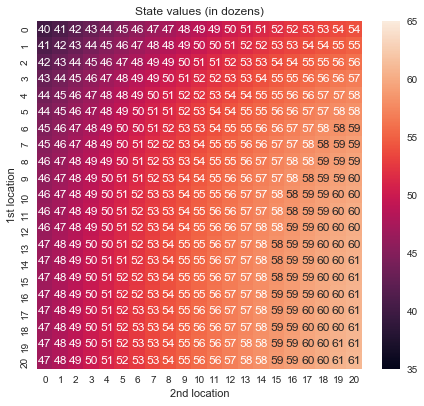

Policy evaluation finished in 26 steps


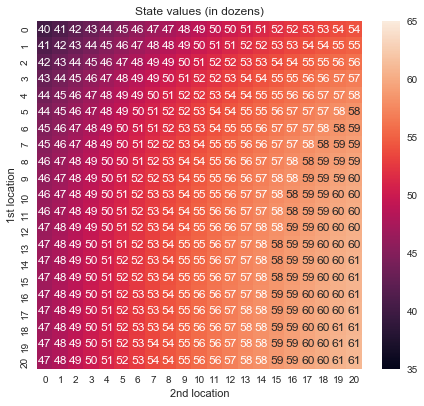

In [4]:
# Initialize arbitrary policy and state values
pi = np.zeros(STATE_SPACE, dtype=np.int)
V = np.zeros(STATE_SPACE, dtype=np.float)

def q_value(n1, n2, action, gamma):
    q = 0.
    for n1_, n2_ in mdp.states_iter():
        p, r = T[n1, n2, action, n1_, n2_]
        q += p * (r + gamma * V[n1_, n2_])
    
    return q

def policy_evaluation(gamma, theta, visualize_each=0):
    i = 0
    while True:
        if visualize_each > 0 and i % visualize_each == 0:
            print("Policy evaluation: {}".format(i))
            visualize(V=V)
            plt.pause(0.05)
        
        V_old = np.copy(V)
        for n1, n2 in mdp.states_iter():
            V[n1, n2] = q_value(n1, n2, pi[n1, n2], gamma=gamma)

        # Early stopping
        max_diff = np.max(np.abs(V_old - V))
        if max_diff < theta:
            print("Policy evaluation finished in {} steps".format(i + 1))
            break
        i += 1

policy_evaluation(gamma=0.9, theta=1., visualize_each=5)
visualize(V=V)

# Policy Improvement

It utilizes one step lookahead to improve current policy based on state values. This is greedy policy which takes the action that looks best in the short term according to current value function.

![policy interation](refs/policy_improv.png)

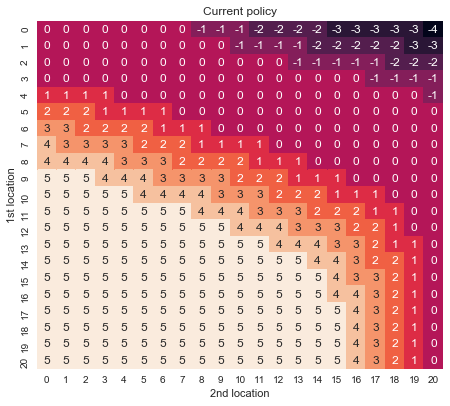

In [5]:
def policy_improvement(gamma):
    changed = False
    for n1, n2 in mdp.states_iter():
        # Get legal actions
        actions = list(mdp.actions_in_state(n1, n2))
        
        # Get state-action value for each legal action
        q_values = list(map(lambda action: q_value(n1, n2, action, gamma=gamma), actions))

        best_a = actions[np.argmax(q_values)]
        if pi[n1, n2] != best_a:
            pi[n1, n2] = best_a
            changed = True
            
    return changed

policy_improvement(gamma=0.9)
visualize(pi=pi)

# Policy Iteration

We evaluate current policy to get current state values and then based on those new values improve policy to take better actions in the future. Then we evaluate better policy to get new "better" states values and then... process iterates until policy doesn't change any more.

![policy interation](refs/policy_iter.png)

Policy iteration step: 0


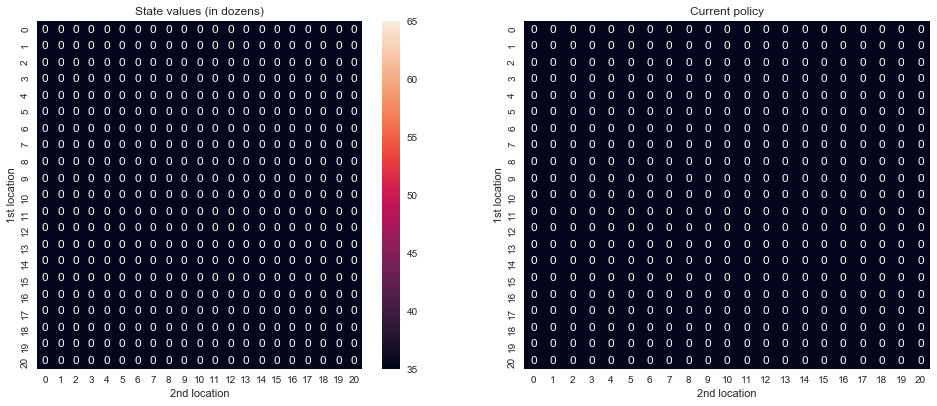

Policy evaluation finished in 26 steps
Policy iteration step: 1


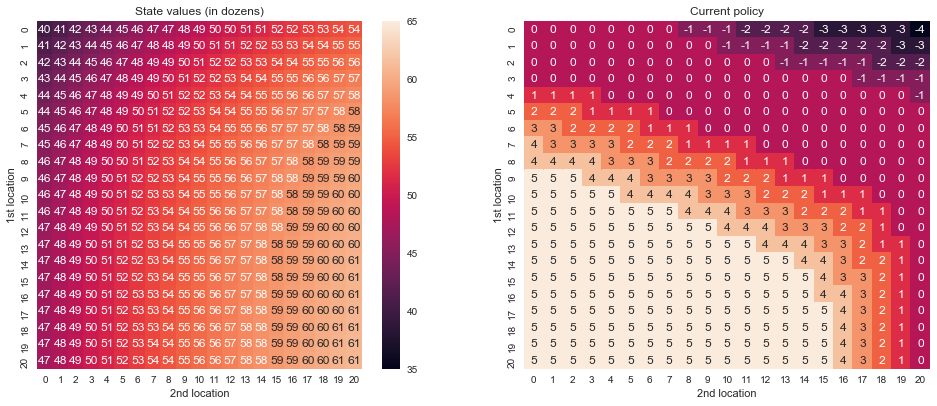

Policy evaluation finished in 8 steps
Policy iteration step: 2


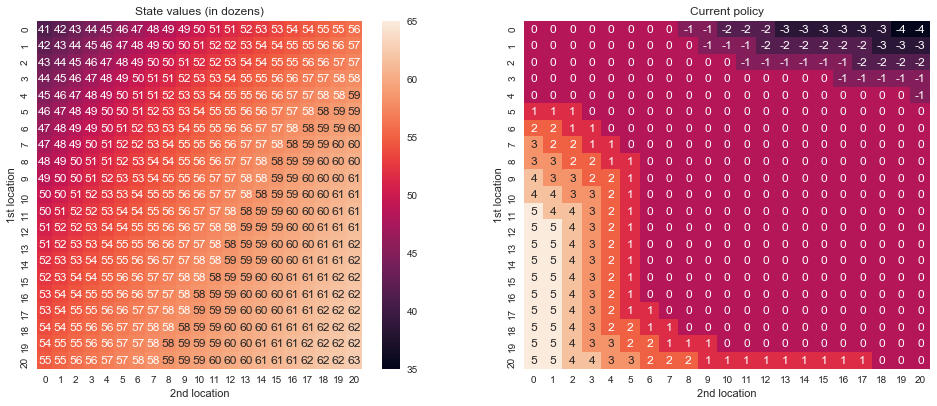

Policy evaluation finished in 6 steps
Policy iteration step: 3


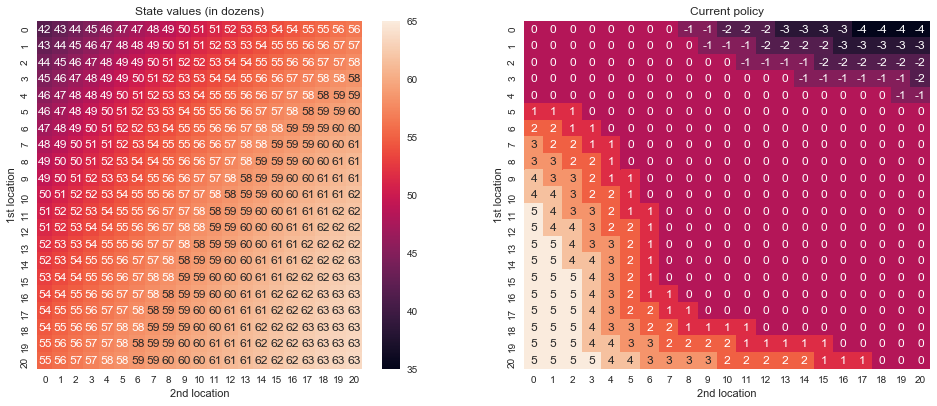

Policy evaluation finished in 1 steps
Policy iteration step: 4


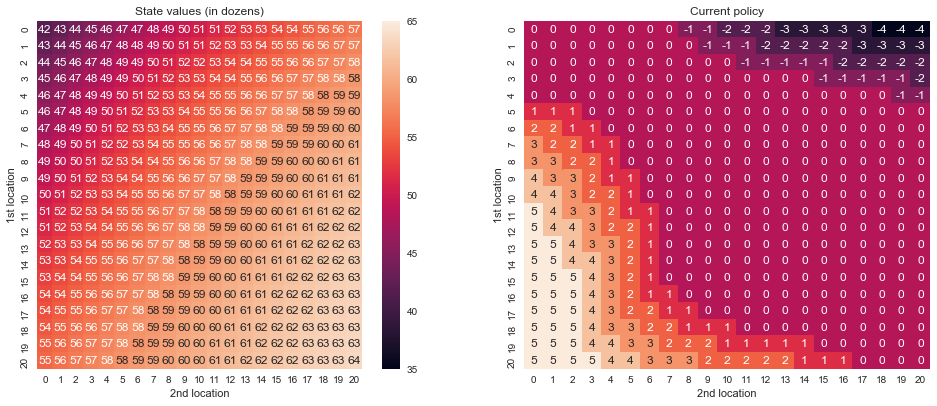

Policy evaluation finished in 1 steps
Policy iteration finished in 5 iterations!


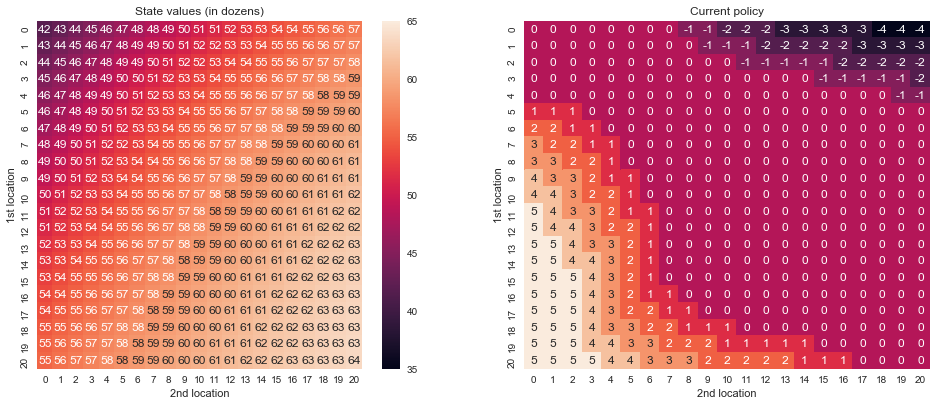

In [6]:
# Initialize arbitrary policy and state values
pi = np.zeros(STATE_SPACE, dtype=np.int)
V = np.zeros(STATE_SPACE, dtype=np.float)

def policy_iteration(gamma=0.9, theta=1.):
    i = 0
    while True:
        ## DO NOT TOUCH, policy and state value visualization ##
        print("Policy iteration step: {}".format(i))
        visualize(pi=pi, V=V)
        plt.pause(0.05)
        
        policy_evaluation(gamma=gamma, theta=theta)
        changed = policy_improvement(gamma=gamma)
        
        if not changed:
            print("Policy iteration finished in {} iterations!".format(i + 1))
            visualize(pi=pi, V=V)
            break
        i += 1

policy_iteration()